In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#
#!ls "/content/drive/MyDrive/Judging under influence/DOCOUT/PARAGRAPHS"

In [ ]:
#!pip install git+https://github.com/tensorflow/docs   
#!pip install pyyaml h5py
import numpy as np
import shutil

import tensorflow as tf
import random
import matplotlib.pyplot as plt
import pandas as pd 
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Bidirectional, Dropout

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import os 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true" #for that erorr in the tuning process

In [ ]:
#Keras do not implement F1 so I implemented "myself"
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#-----input and creating of tensors dataset
data = pd.read_csv("FinalDataset.csv",index_col = 0,low_memory=False,encoding = "ISO-8859-1") #not utf-8 encoded
#data = pd.read_csv("/content/drive/MyDrive/Judging under influence/DOCOUT/PARAGRAPHS/FinalDataset.csv",index_col = 0,low_memory=False,encoding = "ISO-8859-1") #not utf-8 encoded
df=data.filter(["DOCOUT","TEXT"], axis=1)
df=df.dropna() #non applicable deleted atm
df["DOCOUT"]=df["DOCOUT"].astype(int)
df.reset_index(drop=True, inplace=True) 

target = df.pop('DOCOUT')
dataset = tf.data.Dataset.from_tensor_slices((df.TEXT.values, target.values))

df

,TEXT
0,1 . THE QUESTION PUT BY THAT COURT REQUESTS TH...
1,3 . THE GERMAN GOVERNMENT RAISED THE QUESTION ...
2,"2 . THE CENTRALE RAAD REQUESTS THE COURT, IN T..."
3,1 . THE QUESTION ASKED BY THE SAID COURT FIRST...
4,2 . THE CENTRALE RAAD ASKS THE COURT IN THE SE...
...,...
86123,18. The Finanzgericht Düsseldorf (Finance Cour...
86124,16. TSI also submitted that the Principal Cust...
86125,13. Since TSI had declared the handheld partic...
86126,"14. Following an on-site inspection, the Princ..."


In [ ]:
#Here i get the split from the dataset, the split is 80 % for the k-fold and 20% for an independent test set.
#The test set is used to asses the performance on unseen data on the best cv values

#this is used for testing purposes, generates a dataset of nums from 0 to 19
#dataset = tf.data.Dataset.range(20)

DATASET_SIZE = dataset.cardinality().numpy()
SPLITS = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64 #very important! Reducing this in RNN let them run on slower pc at the cost of exec time (increasing does the opposite)
TEST_SIZE = 0.15


def get_dataset_partitions(ds = dataset, ds_size= DATASET_SIZE, n_splits = SPLITS, test_size=TEST_SIZE, shuffle=True, shuffle_size=DATASET_SIZE, BATCH_SIZE = BATCH_SIZE):
    fold_size = 1/n_splits
    split_size = ds_size * (1-test_size) * fold_size
    CV_folds = []
    
    if shuffle:
        # Specify seed=xx to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, reshuffle_each_iteration=False, seed=5)#poi 1996
    
    test_dataset = ds.skip(ds_size * (1-test_size))
    cv_dataset = ds.take(ds_size * (1-test_size))
    
    #print(list(test_dataset.as_numpy_iterator()))
    #print(list(cv_dataset.as_numpy_iterator()))
    
    #print(list(test_dataset.as_numpy_iterator()))
    #print(list(cv_dataset.as_numpy_iterator()))
    
    for i in range(n_splits):         #dataset is divided in 3 pieces for each iteration, train1 | validation | train2 due to take/skip nature
        
        #we will concatenate train1 and train2 to define the fitting split for the current fold while val will be the validation
        
        train1 = cv_dataset.take(i * split_size) #each of the 2 train(1 and 2) can be of size [0,fold_size*num_splits-1], val have dimension= fold_size
        val = cv_dataset.skip(i * split_size).take(split_size)
        train2 = cv_dataset.skip(i * split_size).skip(split_size)
    
      
        #print(list(train1.concatenate(train2).as_numpy_iterator()))
        #print(list(val.as_numpy_iterator()))

        #we generate a list of tuples. Each tuple contain the train/validation for each fold. The list is indeed SPLITS-long.
        CV_folds.append([
                         train1.concatenate(train2).shuffle(train1.concatenate(train2).cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE),
                         val.shuffle(val.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
                        ])
        
        #print("CV:")
        #print(list(CV_folds[i][0].as_numpy_iterator()))
        ##print(list(CV_folds[i][1].as_numpy_iterator()))
        #print("--------------------------------------")
    
    
    return [CV_folds,
            test_dataset.shuffle(test_dataset.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE),
            cv_dataset.shuffle(cv_dataset.cardinality().numpy()).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)]
    


CV_folds, test_dataset, train_ds_final = get_dataset_partitions()

#print(list(test_dataset.as_numpy_iterator()))
#print(list(train_ds_final.as_numpy_iterator()))

In [ ]:
#----- Class Imabalance dealing
labels=[]
labels=np.array(labels)
for example, label in dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).take(-1):
    _ = example.numpy()
    labels=np.concatenate((labels,label.numpy()))
    
#print(len(labels))
nonzero = np.count_nonzero(labels)
print("Number of 1 : "+str(nonzero))
print("Number of 0 : "+str(len(labels)-nonzero))
#positive/total ratio:
posWeight = len(labels)/nonzero
print("Weight of positive elements: "+str(posWeight))

Number of 1 : 16003
Number of 0 : 70125
Weight of positive elements: 5.381990876710617


In [ ]:
#define the metrics I want to see during the iterations
METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      f1, #my f1
      tf.keras.metrics.AUC(name='auc'),
    
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      
      
]

In [ ]:
def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(patience = 9, monitor = 'val_f1',  mode = 'max', min_delta = 0.05, restore_best_weights=True),#ma need an increase?
    #tf.keras.callbacks.TensorBoard('logsGraphs/graphsFolder'),
  ]

## Define CV e Tensoboard params

In [ ]:
#loading of tensorboard and deleting of old logs(windows10 only I guess)
%reload_ext tensorboard
#shutil.rmtree("./logsGraphs", ignore_errors=True, onerror=None)

In [ ]:
#here I defined the parameters i want to iterate through

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64,128]))
HP_EMBEDDING_DIM = hp.HParam('emb_dim', hp.Discrete([64,128]))
HP_OPTIMIZER_LR = hp.HParam('opt_lr', hp.Discrete([ 0.001, 0.0005, 0.0001, 0.00005, 0.00001]))
HP_WEIGHT_TUNER = hp.HParam('pos_weight_tuner', hp.RealInterval(1.0,3.0))#selected later
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([2,3]))#always add +1 per final layer
HP_NUM_EPOCHS = hp.HParam('num_epochs', hp.Discrete([40]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))#check adam / remove
#HP_KERNEL_REGULARIZATION_L2 = hp.HParam('ker_l2', hp.Discrete([1e-25, 1e-4, 1e-5, 1e-6, 1e-7]))
#HP_KERNEL_REGULARIZATION_L1 = hp.HParam('ker_l1', hp.Discrete([1e-25, 1e-4, 1e-5, 1e-6, 1e-7]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.25, 0.3]))


#here we choose the metrics we want to average after CV, we only choose the most important ones to do not loose the focus
METRIC1 = 'f1'
METRIC2 = 'auc'#attention! If we have 0 precision/recall we might have errors due to AUC implmentation, MAY BE REMOVED

with tf.summary.create_file_writer('logsGraphs/hparam_tuningCV').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_EMBEDDING_DIM, HP_OPTIMIZER_LR, HP_WEIGHT_TUNER, HP_NUM_LAYERS, HP_NUM_EPOCHS,HP_OPTIMIZER, HP_DROPOUT],
    metrics=[hp.Metric(METRIC1, display_name='f1'),hp.Metric(METRIC2, display_name='auc')],
  )



## Define the CV model

In [ ]:
#this is the function that creates the ANN given the parameters.
#after creating it the ANN is fitted on the current split's train set and vchecked on the current validation set
#we return the f1 and auc of the current validation split as the measure of performance of this split
#the f1 and auc over all the splits will be later averaged and will be the parameters performance

VOCAB_SIZE = 30000#define size of vocabulary, as it says

def train_test_model(emb_dim, num_units, learning_rate, weight_normalizer, num_layers, train_dataset, val_dataset, num_epochs, optimizer, dropout):
  
  encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
  encoder.adapt(train_dataset.map(lambda text, label: text))

#---------------------------------------------------------------------
  model = Sequential([
      
  encoder,
    
  Embedding(#embedding layer
        input_dim=len(encoder.get_vocabulary()),
        output_dim=emb_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    
  #Bidirectional(tf.keras.layers.LSTM(emb_dim , dropout = 0.1,return_sequences=True)),
  
  Bidirectional(tf.keras.layers.LSTM(emb_dim , dropout = 0.15)),    
  #Dropout(dropout)

  ])
    
  for i in range(num_layers):
    if num_units/pow(2,i) >1 :
        model.add(Dense(num_units/pow(2,i), activation="relu"))
        #model.add(Dropout(dropout))
            
  model.add(Dense(1,activation='sigmoid')) 


  class_weight = {0: 1., #class 0 weight
                  1: posWeight/weight_normalizer, #uses the weight I set to make them perfectly balanced, I can increase it to overweight pos class!
                                     
                  2: 2.} 
    

  if optimizer == 'adam':
      model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=METRICS,
      )
  if optimizer == 'sgd':
    model.compile(
          optimizer=tf.keras.optimizers.SGD(learning_rate),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=METRICS,
      )

  history = model.fit(
             train_dataset,
             epochs=num_epochs,
             class_weight=class_weight,
             validation_data = val_dataset,
             callbacks=get_callbacks()
             ) 

  _, prec, recall, f1,auc, tp, tn, fp, fn, accuracy = model.evaluate(val_dataset)#validation we get our performances from this performance assesment
  del model
  del train_dataset
  del val_dataset
  return f1,auc, history#take only the most important measures to retain the focus

In [ ]:
#this method runs the cross validation, calling the above method giving it the parameters choosen and recording performances 
#it computes the average of f1 and auc over the various splits as well

def run(run_dir, hparams, session_num):
  with tf.summary.create_file_writer(run_dir).as_default():
    # record the values used in this trial
    hp.hparams(hparams)
    f1Score,auc = 0,0
    history={}
    
    for i in range(SPLITS):#averaging over all the splits
      print("\nCHECKING SPLIT NUM: "+str(i+1))
      train_dataset,val_dataset = CV_folds[i]
      tmpf1,tmpauc,history["split "+str(i+1)] =  train_test_model(emb_dim = hparams[HP_EMBEDDING_DIM],
                                                  num_units = hparams[HP_EMBEDDING_DIM],#num_units = embedding best practice
                                                  learning_rate = hparams[HP_OPTIMIZER_LR],
                                                  weight_normalizer= hparams[HP_WEIGHT_TUNER],
                                                  num_layers = hparams[HP_NUM_LAYERS],
                                                  num_epochs = hparams[HP_NUM_EPOCHS],
                                                  optimizer = hparams[HP_OPTIMIZER],
                                                  dropout = hparams[HP_DROPOUT],
                                                  train_dataset = train_dataset,
                                                  val_dataset = val_dataset)
      f1Score += tmpf1
      auc += tmpauc
      
    
    f1Score /= SPLITS
    auc /= SPLITS
    
    print("!!! SESSION NUM "+str(session_num)+" ---> CV f1: "+str(f1Score))
    print("!!! auc: "+str(auc)+"\n------------------------------------------")
    
    plotter = tfdocs.plots.HistoryPlotter(metric = 'f1', smoothing_std=10)
    plotter.plot(history)
    plt.show()
    print("\n------------------------------------------")
    
    plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
    plotter.plot(history)
    plt.show()
    
    tf.summary.scalar(METRIC1, f1Score, step = tf.convert_to_tensor(1, dtype=tf.int64))
    tf.summary.scalar(METRIC2, auc, step = tf.convert_to_tensor(1, dtype=tf.int64))

## Run the tuning model

In [ ]:
#run numbr 130

#results: 0.5632338374853134,0.8369264602661133

Trying parameters given by user
!--WARNING--! DROPOUT is used only in recurrent layers
--- Starting trial: run-1
{'num_units': 167, 'emb_dim': 204, 'opt_lr': 2.52851212e-05, 'pos_weight_tuner': 5.02595145, 'num_layers': 3, 'num_epochs': 40, 'optimizer': 'adam', 'dropout': 0.2}

CHECKING SPLIT NUM: 1
Epoch 1/40
861/862 [============================>.] - ETA: 0s - loss: 0.5224 - precision: 0.5533 - recall: 0.0276 - f1: 8.7819e-04 - auc: 0.6015 - tp: 353.0000 - tn: 55812.0000 - fp: 285.0000 - fn: 12434.0000 - accuracy: 0.8154
Epoch: 0, accuracy:0.8154,  auc:0.6015,  f1:0.0009,  fn:12437.0000,  fp:285.0000,  loss:0.5224,  precision:0.5533,  recall:0.0276,  tn:55827.0000,  tp:353.0000,  val_accuracy:0.8187,  val_auc:0.6640,  val_f1:0.0000,  val_fn:2499.0000,  val_fp:0.0000,  val_loss:0.4627,  val_precision:0.0000,  val_recall:0.0000,  val_tn:11281.0000,  val_tp:0.0000,  
862/862 [==============================] - 72s 73ms/step - loss: 0.5224 - precision: 0.5533 - recall: 0.0276 - f1: 8.7718

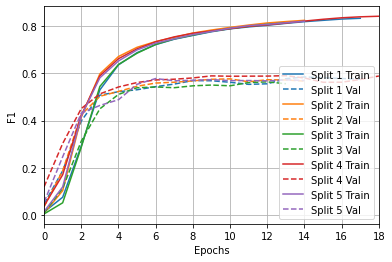


------------------------------------------


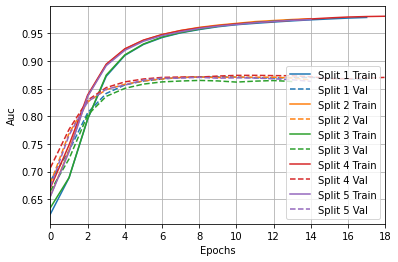

In [ ]:
#this is the highest-level method that runs the 2 above, call many times the run(....) method with different params combination

#you can choose: 1) to iterate one after all the paramters (not working atm, need to be added optimzier and num-epochs params)
#                2) Sample randomly from the paramters we have, useful for having a general idea of the performances

#the HParams framework is taken form the Tensorflow webpage as a "standard" hyperparameter optimization framework

def run_tuning(random_parameters):
    #take the user gin parameters
    if not random_parameters :
        print("Trying parameters given by user")
                 
        session_num = 1
        #this while is here simply because after around 20/25 combinations Colab RAM/my pc RAM is full and i need to restart
        
        num_units = int(1.67978975e+02)

        emb_dim = int(2.04549913e+02)
        opt_lr = 2.52851212e-05
        weight_tuner = 5.02595145e+00
        num_layers = int(3.08611230e+00)
        num_epochs = 40
        optimizer = random.choice(HP_OPTIMIZER.domain.values)
        #ker_l2 = random.choice(HP_KERNEL_REGULARIZATION_L2.domain.values)
        #ker_l1 = random.choice(HP_KERNEL_REGULARIZATION_L1.domain.values)
        
        #USED ONLY IN RNN!!!
        dropout = 0.2
        #creates a dictionary with the random sampled parameters, taken at random every time

        hparams = {
          HP_NUM_UNITS: num_units, #num un= emb_dim
          HP_EMBEDDING_DIM: emb_dim,
          HP_OPTIMIZER_LR: opt_lr,
          HP_WEIGHT_TUNER: weight_tuner,
          HP_NUM_LAYERS: num_layers,
          HP_NUM_EPOCHS: num_epochs,
          HP_OPTIMIZER: optimizer,
          #HP_KERNEL_REGULARIZATION_L2: ker_l2,
          #HP_KERNEL_REGULARIZATION_L1: ker_l1
          HP_DROPOUT: dropout
        }

        run_name = "run-%d" % session_num

        print("!--WARNING--! DROPOUT is used only in recurrent layers")

        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})

        #call the run(..) method defined earlier
        run('logsGraphs/hparam_tuningCV/' + run_name, hparams, session_num)


            
              
    if random_parameters :
        print("Trying parameters at random")
                 
        session_num = 0
        #this while is here simply because after around 20/25 combinations Colab RAM/my pc RAM is full and i need to restart
        while session_num <= 50:
            num_units = random.choice(HP_NUM_UNITS.domain.values)
            emb_dim = random.choice(HP_EMBEDDING_DIM.domain.values)
            
            opt_lr = random.choice(HP_OPTIMIZER_LR.domain.values)
            weight_tuner = random.choice([0.3, 0.5, 0.7, 1.1, 1.3, 1.5])
            num_layers = random.choice(HP_NUM_LAYERS.domain.values)
            num_epochs = random.choice(HP_NUM_EPOCHS.domain.values)
            optimizer = random.choice(HP_OPTIMIZER.domain.values)
            dropout = random.choice(HP_DROPOUT.domain.values)
            
            #creates a dictionary with the random sampled parameters, taken at random every time
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_EMBEDDING_DIM: emb_dim,
              HP_OPTIMIZER_LR: opt_lr,
              HP_WEIGHT_TUNER: weight_tuner,
              HP_NUM_LAYERS: num_layers,
              HP_NUM_EPOCHS: num_epochs,
              HP_OPTIMIZER: optimizer,
              HP_DROPOUT: dropout
            }

            run_name = "run-%d" % session_num
            print("!--WARNING--! DROPOUT is used only in recurrent layers")
            
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            #call the run(..) method defined earlier
            run('logsGraphs/hparam_tuningCV/' + run_name, hparams, session_num)
            session_num += 1

                
run_tuning(random_parameters=False)

In [ ]:
#%reload_ext tensorboard
#%tensorboard --logdir 'logsGraphs/hparam_tuningCV/' --host localhost --port 9089

## Final Refit on the retained Test_set

In [ ]:
def get_callbacks():
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(patience = 7, monitor = 'val_f1',  mode = 'max', min_delta = 0.05),#ma need an increase?
    #tf.keras.callbacks.TensorBoard('logsGraphs/graphsFolder'),
  ]

In [ ]:

METRICS = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      f1, #my f1
      tf.keras.metrics.AUC(name='auc'),
    
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      
      
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
#----- Class Imabalance dealing here
labels=np.array([])
for example, label in test_dataset.take(-1):
    labels=np.concatenate((labels,label.numpy()))
    
nonzero = np.count_nonzero(labels)
print("Test set Number of 1 : "+str(nonzero))
print("Test set Number of 0 : "+str(len(labels)-nonzero))

Test set Number of 1 : 3213
Test set Number of 0 : 14013


In [ ]:
#redefine the encoding on the WHOLE train set (80% of the dataset)
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds_final.map(lambda text, label: text))

In [ ]:
#these best are the best of the leaked models, they seem to have good perormances here as well 

#Absolute best: {'num_units': 128, 'emb_dim': 256, 'opt_lr': 0.005, 'pos_weight_tuner': 1.7}
#run-22: {'num_units': 128, 'emb_dim': 256, 'opt_lr': 0.005, 'pos_weight_tuner': 1.3}
#run-19: {'num_units': 128, 'emb_dim': 256, 'opt_lr': 0.001, 'pos_weight_tuner': 1.7}
#run-46: {'num_units': 256, 'emb_dim': 256, 'opt_lr': 0.001, 'pos_weight_tuner': 1.2}
#embedding_dim = 256
#weight_divider = 1.7
#num_units = 128
#learning_rate = 0.005
#num_layers = 5
#num_epochs = 20
#kernel_l1 =0

In [ ]:
num_units = int(1.67978975e+02)

emb_dim = int(2.04549913e+02)
learning_rate = 2.52851212e-05
weight_normalizer = 5.02595145e+00
num_layers = int(3.08611230e+00)



In [ ]:


model = Sequential([
      
    encoder,

    Embedding(#embedding layer
        input_dim=len(encoder.get_vocabulary()),
        output_dim=emb_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),

    #Bidirectional(tf.keras.layers.LSTM(emb_dim , dropout = 0.1,return_sequences=True)),

    Bidirectional(tf.keras.layers.LSTM(emb_dim , dropout = 0.15))
    #Dropout(dropout)

    ])
    
for i in range(num_layers):
    if num_units/pow(2,i) >1 :
        model.add(Dense(num_units/pow(2,i), activation="relu"))
        #model.add(Dropout(dropout))

model.add(Dense(1,activation='sigmoid')) 


class_weight = {0: 1., #class 0 weight
              1: posWeight/weight_normalizer, #uses the weight I set to make them perfectly balanced, I can increase it to overweight pos class!

              2: 2.} 




In [ ]:
model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=METRICS,
      )



#----fitting
history = model.fit(train_ds_final, 
                    epochs = 50, 
                    #validation_steps=20, #uses only a portion of validation set
                    class_weight=class_weight,
                    validation_data=test_dataset,
                    callbacks=get_callbacks())


Epoch 1/50


2022-04-14 12:12:54.265220: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


4306/4307 [============================>.] - ETA: 0s - loss: 0.4773 - precision: 0.5806 - recall: 0.0177 - f1: 0.0223 - auc: 0.6579 - tp: 227.0000 - tn: 55943.0000 - fp: 164.0000 - fn: 12562.0000 - accuracy: 0.8153
Epoch: 0, accuracy:0.8153,  auc:0.6579,  f1:0.0223,  fn:12563.0000,  fp:164.0000,  loss:0.4773,  precision:0.5806,  recall:0.0177,  tn:55948.0000,  tp:227.0000,  val_accuracy:0.8246,  val_auc:0.7869,  val_f1:0.2102,  val_fn:2683.0000,  val_fp:339.0000,  val_loss:0.3992,  val_precision:0.6099,  val_recall:0.1650,  val_tn:13674.0000,  val_tp:530.0000,  
4307/4307 [==============================] - 229s 51ms/step - loss: 0.4773 - precision: 0.5806 - recall: 0.0177 - f1: 0.0223 - auc: 0.6579 - tp: 227.0000 - tn: 55948.0000 - fp: 164.0000 - fn: 12563.0000 - accuracy: 0.8153 - val_loss: 0.3992 - val_precision: 0.6099 - val_recall: 0.1650 - val_f1: 0.2102 - val_auc: 0.7869 - val_tp: 530.0000 - val_tn: 13674.0000 - val_fp: 339.0000 - val_fn: 2683.0000 - val_accuracy: 0.8246
Epoch 2/

In [ ]:
history2={}
history2["split "+str(i+1)]=history
history= history2

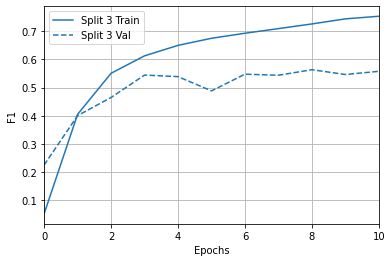

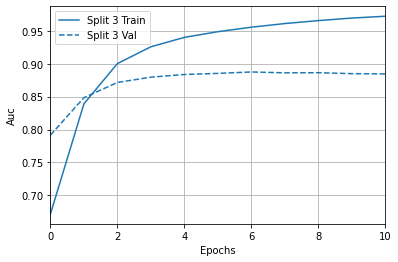

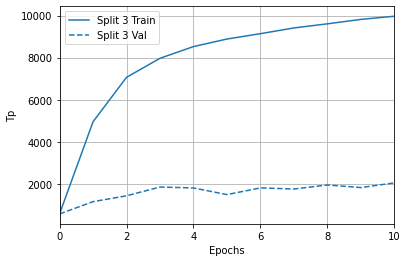

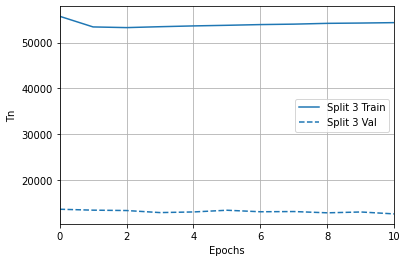

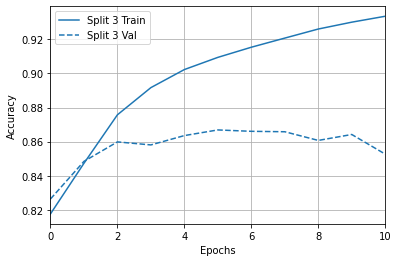

1077/1077 [==============================] - 22s 20ms/step - loss: 0.3784 - precision: 0.5944 - recall: 0.6446 - f1: 0.5618 - auc: 0.8846 - tp: 2071.0000 - tn: 12600.0000 - fp: 1413.0000 - fn: 1142.0000 - accuracy: 0.8517
Test Accuracy: 0.8516777157783508
Test Prec: 0.5944316983222961
Test Recall: 0.644568920135498
Test AUC: 0.8845880627632141
Test F1:  0.5617635846138
Test Loss: 0.37838271260261536


In [ ]:
#1 solo layer ora
plotter = tfdocs.plots.HistoryPlotter(metric = 'f1', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'tp', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'tn', smoothing_std=10)
plotter.plot(history)
plt.show() 

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history)
plt.show() 

#get you result on the independent test set to asses performance on unseen data
test_loss,  test_prec, test_rec, test_f1, test_auc,_1,_2,_3,_4,test_acc = model.evaluate(test_dataset)


print('Test Accuracy:', test_acc)
print('Test Prec:', test_prec)
print('Test Recall:', test_rec)
print('Test AUC:', test_auc)
print('Test F1: ',test_f1)
print('Test Loss:', test_loss)

## Save the model for future usage

In [ ]:
model.save('DOCOUT_RNN_PARAGRAPHS',save_format='tf')

INFO:tensorflow:Assets written to: DOCOUT_RNN_JUDGS/assets


INFO:tensorflow:Assets written to: DOCOUT_RNN_JUDGS/assets


In [ ]:
#loaded_model.load_weights()
#we set compile=False because of the custom losses that can't be loaded 
new_model = tf.keras.models.load_model('DOCOUT_RNN_PARAGRAPHS',compile=False)
new_model.summary()

2022-04-14 14:13:24.967844: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-14 14:13:24.980921: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-14 14:13:28.692793: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-14 14:13:29.065571: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-04-14 14:13:29.078602: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 204)         12240000  
                                                                 
 bidirectional (Bidirectiona  (None, 408)              667488    
 l)                                                              
                                                                 
 dense (Dense)               (None, 167)               68303     
                                                                 
 dense_1 (Dense)             (None, 83)                13944     
                                                                 
 dense_2 (Dense)             (None, 41)                3

In [ ]:
new_model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=METRICS,
      )



In [ ]:

#get you result on the independent test set to asses performance on unseen data
test_loss,  test_prec, test_rec, test_f1, test_auc,_1,_2,_3,_4,test_acc = new_model.evaluate(test_dataset)


print('Test Accuracy:', test_acc)
print('Test Prec:', test_prec)
print('Test Recall:', test_rec)
print('Test AUC:', test_auc)
print('Test F1: ',test_f1)
print('Test Loss:', test_loss)

1077/1077 [==============================] - 27s 21ms/step - loss: 0.3784 - precision: 0.5944 - recall: 0.6446 - f1: 0.5692 - auc: 0.8846 - tp: 6213.0000 - tn: 37800.0000 - fp: 4239.0000 - fn: 3426.0000 - accuracy: 0.8517
Test Accuracy: 0.8516777157783508
Test Prec: 0.5944316983222961
Test Recall: 0.644568920135498
Test AUC: 0.8845880627632141
Test F1:  0.5692134499549866
Test Loss: 0.3783823847770691


## Dummy predictor

In [ ]:
from sklearn.metrics import recall_score,precision_score,roc_curve,roc_auc_score,f1_score,accuracy_score

test_labels=[]
test_labels=np.array(test_labels)
for example, label in test_dataset.take(-1):
    _ = example.numpy()
    test_labels=np.concatenate((test_labels,label.numpy()))
    
#print(test_labels)

#Results using dummy classification on the test set
accuracy = accuracy_score(test_labels,np.zeros(len(test_labels)))#predict all zeroes
precision = precision_score(test_labels,np.zeros(len(test_labels)))
recall = recall_score(test_labels,np.zeros(len(test_labels)))
auc = roc_auc_score(test_labels,np.zeros(len(test_labels)))
f1 = f1_score(test_labels,np.zeros(len(test_labels)))



print("Precision : "+str(precision))
print("Recall : "+str(recall))
print("AUC : "+str(auc))
print("F1 : "+str(f1))
print("accuracy: "+str(accuracy))

Precision : 0.0
Recall : 0.0
AUC : 0.5
F1 : 0.0
accuracy: 0.8134796238244514


/home/alessandro/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
